<a href="https://colab.research.google.com/github/Armin-Abdollahi/Bone-Age-Estimation/blob/main/Bone_Age_EfficientNetV2S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EfficientNetV2S-based Regression Model

Refrence Paper:
https://www.mdpi.com/2075-1729/14/6/774

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2S

In [3]:
# Load the labels
labels_path = '/content/drive/MyDrive/Digital_Hand_Atlas_Dataset/Total_Images/Bordered_XRay_Images/Label.csv'
labels = pd.read_csv(labels_path)

In [4]:
labels['Case ID'] = labels['Case ID'].apply(lambda x: str(x)+'.jpg')

labels.head()

,Case ID,Bone Age,Male,Location
0,1.jpg,0,False,Asian
1,2.jpg,0,False,Asian
2,3.jpg,0,False,Asian
3,4.jpg,0,False,Asian
4,5.jpg,0,False,Asian


In [5]:
# Ensure the 'Case ID' column is of type string
labels['Case ID'] = labels['Case ID'].astype(str)

In [6]:
# Create the image data generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [7]:
# Create the train and validation generators
train_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/drive/MyDrive/Digital_Hand_Atlas_Dataset/Total_Images/Bordered_XRay_Images',
    x_col='Case ID',
    y_col='Bone Age',
    target_size=(260, 260),  # EfficientNetV2S expects input size of 260x260
    color_mode='rgb',  # EfficientNetV2S expects 3 channels
    class_mode='raw',
    batch_size=32,
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/drive/MyDrive/Digital_Hand_Atlas_Dataset/Total_Images/Bordered_XRay_Images',
    x_col='Case ID',
    y_col='Bone Age',
    target_size=(260, 260),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    subset='validation'
)

Found 5915 validated image filenames.
Found 1478 validated image filenames.


In [8]:
# Load the EfficientNetV2S model pre-trained on ImageNet
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(260, 260, 3))

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)  # Linear activation for regression

In [11]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae', 'accuracy'])

In [13]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 2391s 12s/step - accuracy: 0.0528 - loss: 26.3501 - mae: 4.0358 - val_accuracy: 0.0679 - val_loss: 7.1856 - val_mae: 2.2101
Epoch 2/10
  1/184 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - accuracy: 0.0938 - loss: 6.0463 - mae: 1.8947

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.0938 - loss: 6.0463 - mae: 1.8947 - val_accuracy: 0.0000e+00 - val_loss: 7.9205 - val_mae: 2.2208
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.0570 - loss: 9.0805 - mae: 2.3178 - val_accuracy: 0.0679 - val_loss: 5.8645 - val_mae: 1.8321
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 187ms/step - accuracy: 0.0312 - loss: 5.9198 - mae: 2.0423 - val_accuracy: 0.0000e+00 - val_loss: 2.9940 - val_mae: 1.6108
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.0524 - loss: 7.5012 - mae: 2.0882 - val_accuracy: 0.0679 - val_loss: 7.1624 - val_mae: 2.2617
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - accuracy: 0.0312 - loss: 6.5505 - mae: 2.1504 - val_accuracy: 0.0000e+00 - val_loss: 11.0838 - val_mae: 3.0175
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.0554 - loss: 7.4144 - mae: 2.0624 - val_accuracy: 0.0673 - val_loss: 5.4201 - val_mae: 1.7278
Epoch 8/10
184/184 ━━━━━━━━━━

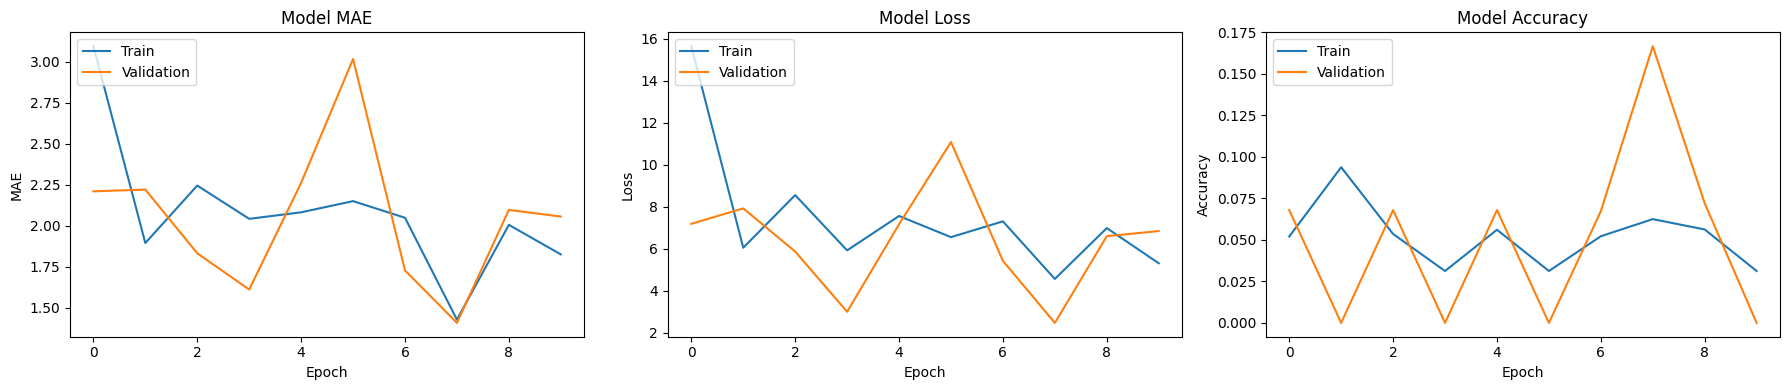

In [14]:
# Plot training & validation MAE values
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=18
)

Epoch 1/18


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 6031s 31s/step - accuracy: 0.0534 - loss: 24.6922 - mae: 3.9705 - val_accuracy: 0.0679 - val_loss: 6.5419 - val_mae: 2.0410
Epoch 2/18
  1/184 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.0625 - loss: 9.2943 - mae: 2.3942

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


184/184 ━━━━━━━━━━━━━━━━━━━━ 32s 172ms/step - accuracy: 0.0625 - loss: 9.2943 - mae: 2.3942 - val_accuracy: 0.0000e+00 - val_loss: 8.1585 - val_mae: 1.9943
Epoch 3/18
184/184 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.0502 - loss: 9.2540 - mae: 2.3432 - val_accuracy: 0.0686 - val_loss: 5.5324 - val_mae: 1.8085
Epoch 4/18
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 189ms/step - accuracy: 0.0312 - loss: 4.4254 - mae: 1.6295 - val_accuracy: 0.0000e+00 - val_loss: 2.0959 - val_mae: 1.3477
Epoch 5/18
184/184 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.0534 - loss: 7.4581 - mae: 2.0767 - val_accuracy: 0.0673 - val_loss: 6.0307 - val_mae: 1.9996
Epoch 6/18
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 190ms/step - accuracy: 0.0312 - loss: 6.7500 - mae: 2.1274 - val_accuracy: 0.1667 - val_loss: 3.1170 - val_mae: 1.3997
Epoch 7/18
184/184 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - accuracy: 0.0563 - loss: 6.9097 - mae: 2.0007 - val_accuracy: 0.0679 - val_loss: 5.9455 - val_mae: 1.9704
Epoch 8/18
184/184 ━━━━━━━━━━━━

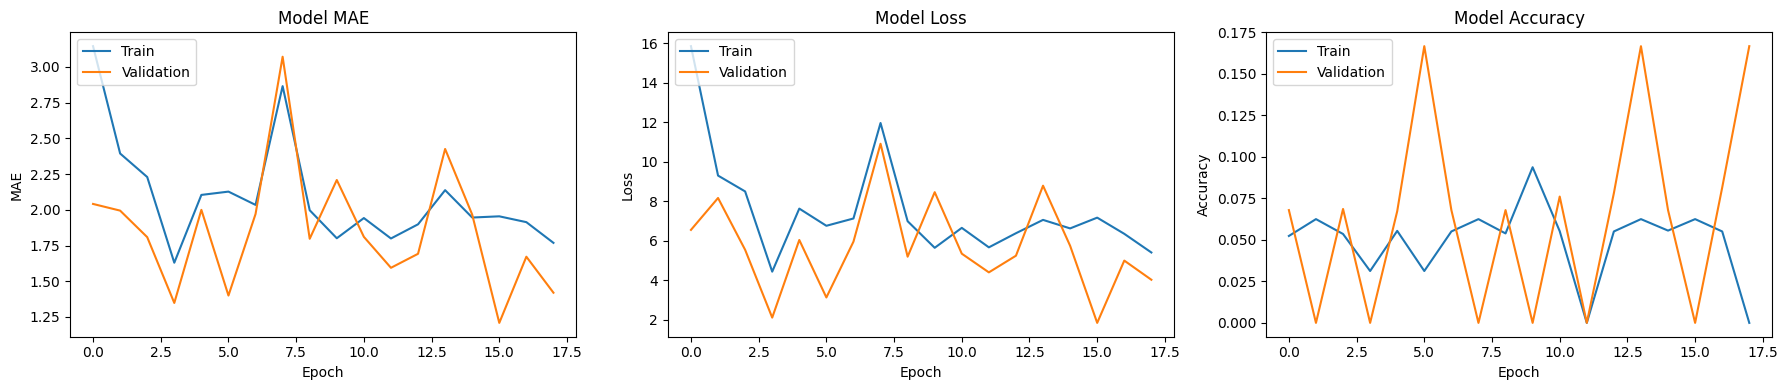

In [ ]:
# Plot training & validation MAE values
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()